<a href="https://colab.research.google.com/github/jade-lam/Springboard-DSC/blob/master/7.6%20Capstone_2_Data_Wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Capstone 2 - Forecasting 2021 Gold Prices**


Data Wrangling - The Thinking Process:


*   With the objective to forecast Gold Price in 2021, given the unknown economic environment, the suggested way is to examine the historic trend of gold against a list of macroeconimic data

*   The suggested baseline to use in order to predict 2021 Gold price would be Gold Price and macroeconomic data for the period of 2010-2020




The list of data points to be used in this project:


*   Gold Price per ounce - from Quandl
*   S&P500, US Dollar Index, 10-Yr Treasury note data - from Yahoo Finance
*   US GPD, Real GDP, Fed Balance Sheet data - from FRED






The Data Wrangling Process:


*   Consolidating all data points into a time-series dataframe
*   Missing data will be filled in by the interpolate method to maintain the trend


*   Given all macroeconomic data has a different base/ figure, the dataset will be scaled to ensure they are comparable
*   Identify trends and correlation from the dataset against gold price





In [ ]:
#importing libraries
import pandas as pd
from pandas_datareader import data
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
import seaborn as sns
from sklearn.preprocessing import scale
import functools
from functools import reduce

In [ ]:
#API Keys
Quandl_API_Keys = 'ev8cegW3ixmoWcZoWvm3'

In [ ]:
#retrieving Quandl datasets - Gold Price 
url = 'https://www.quandl.com/api/v3/datasets/LBMA/GOLD.json?api_key=' + Quandl_API_Keys
gfilter = url + "&start_date=2010-10-01&end_date=2020-12-31"
r = requests.get(gfilter)
goldpriceraw = r.json()
type(goldpriceraw)

dict

In [ ]:
#putting gold price data into dataframe
rows = []
for data in goldpriceraw['dataset']['data']:
  rows.append(data)

gold_dummy = pd.DataFrame(rows)
gold_dummy[0] = pd.to_datetime(gold_dummy[0], format='%Y-%m-%d')
goldprice10yr = gold_dummy[[0,2]]
goldprice10yr.columns = ['Date', 'Gold Price (USD/ Oz)']
goldprice10yr.head()

,Date,Gold Price (USD/ Oz)
0,2020-11-17,1889.05
1,2020-11-16,1885.60
2,2020-11-13,1890.90
3,2020-11-12,1874.85
4,2020-11-11,1860.95


In [ ]:
goldprice10yr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2561 entries, 0 to 2560
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  2561 non-null   datetime64[ns]
 1   Gold Price (USD/ Oz)  2541 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 40.1 KB


In [ ]:
#retrieving Quandl datasets - US Inflation index (based on CPI)
url = 'https://www.quandl.com/api/v3/datasets/FRBC/USINFL.json?api_key=' + Quandl_API_Keys
cpifilter = url + "&start_date=2010-10-01&end_date=2020-12-31"
r = requests.get(cpifilter)
cpiraw = r.json()
type(cpiraw)

dict

In [ ]:
#putting gold price data into dataframe
#CPI-Index used is for all items (SA; 1982-84=100)
cpirows = []
for data in cpiraw['dataset']['data']:
  cpirows.append(data)

cpi_dummy = pd.DataFrame(cpirows)
cpi_dummy[0] = pd.to_datetime(cpi_dummy[0], format='%Y-%m-%d')
cpi10yr = cpi_dummy[[0,1]]
cpi10yr.columns = ['Date', 'CPI']
cpi10yr.head()

,Date,CPI
0,2020-09-01,260.209
1,2020-08-01,259.681
2,2020-07-01,258.723
3,2020-06-01,257.214
4,2020-05-01,255.768


In [ ]:
cpi10yr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    120 non-null    datetime64[ns]
 1   CPI     120 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.0 KB


In [ ]:
#retrieving Yahoo Finance datasets - S&P500, US Dollar Index, 10-year Treasury notes
tickers = ["^GSPC", "DX-Y.NYB", "^TNX"]

today = datetime.now().strftime("%Y-%m-%d")
start = "2010-01-01"
stock_df=pd.DataFrame()

# retrieves daily closing price at the given period
for ticker in tickers:
  stock_df[ticker]= data.DataReader(ticker, "yahoo", start, today)["Close"].round(2)

stock_df.rename(columns={"^GSPC": "S&P500", "DX-Y.NYB": "USD Index", "^TNX": "10-yr T.Note"}, inplace=True)
stock_df.reset_index(inplace=True)
stock_df.head()

,Date,S&P500,USD Index,10-yr T.Note
0,2010-01-04,1132.99,77.53,3.84
1,2010-01-05,1136.52,77.62,3.76
2,2010-01-06,1137.14,77.49,3.81
3,2010-01-07,1141.69,77.91,3.82
4,2010-01-08,1144.98,77.47,3.81


In [ ]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2740 entries, 0 to 2739
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          2740 non-null   datetime64[ns]
 1   S&P500        2740 non-null   float64       
 2   USD Index     2719 non-null   float64       
 3   10-yr T.Note  2718 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 85.8 KB


In [ ]:
#retrieving FRED - US GPD, Real GDP, Fed Balance Sheet

url_gdp = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=GDP&scale=left&cosd=2010-01-01&coed=2020-07-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Quarterly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2020-11-17&revision_date=2020-11-17&nd=1947-01-01"
url_real_gdp = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=GDPC1&scale=left&cosd=1947-01-01&coed=2020-07-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Quarterly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2020-11-17&revision_date=2020-11-17&nd=1947-01-01"
url_fedraw = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=WALCL&scale=left&cosd=2002-12-18&coed=2020-11-11&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Weekly%2C%20As%20of%20Wednesday&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2020-11-17&revision_date=2020-11-17&nd=2002-12-18"

#GDP - unit of measure in billion dollars USD
gdpraw = pd.read_csv(url_gdp)
gdpraw['DATE'] = pd.to_datetime(gdpraw['DATE'], format='%Y-%m-%d')
gdpraw.rename(columns={'DATE': 'Date', 'GDP': 'GDP (bil USD)'}, inplace=True)

#Real GDP - unit of measure in billion dollars USD
realgdpraw = pd.read_csv(url_real_gdp) 
realgdpraw['DATE'] = pd.to_datetime(realgdpraw['DATE'], format='%Y-%m-%d')
realgdpraw.rename(columns={'DATE': 'Date', 'GDPC1': 'Real GDP (bil USD)'}, inplace=True)

#Fed Balance Sheet - unit of measure in million dollars USD
fedraw = pd.read_csv(url_fedraw)
fedraw['DATE'] = pd.to_datetime(fedraw['DATE'], format='%Y-%m-%d')
fedraw.rename(columns={'DATE': 'Date', 'WALCL': 'Fed B/S (mil USD)'}, inplace=True)

In [ ]:
gdpraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           43 non-null     datetime64[ns]
 1   GDP (bil USD)  43 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 816.0 bytes


In [ ]:
realgdpraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                295 non-null    datetime64[ns]
 1   Real GDP (bil USD)  295 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.7 KB


In [ ]:
fedraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               935 non-null    datetime64[ns]
 1   Fed B/S (mil USD)  935 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.7 KB


In [ ]:
#merge multiple dataframes together
dfs = [goldprice10yr, cpi10yr, stock_df, gdpraw, realgdpraw, fedraw]

dfraw = reduce(lambda left,right: pd.merge(left,right,on='Date', how='left'), dfs)
dfraw.head()

,Date,Gold Price (USD/ Oz),CPI,S&P500,USD Index,10-yr T.Note,GDP (bil USD),Real GDP (bil USD),Fed B/S (mil USD)
0,2020-11-17,1889.05,NaN,3609.53,92.42,0.87,NaN,NaN,NaN
1,2020-11-16,1885.60,NaN,3626.91,92.57,0.91,NaN,NaN,NaN
2,2020-11-13,1890.90,NaN,3585.15,92.76,0.89,NaN,NaN,NaN
3,2020-11-12,1874.85,NaN,3537.01,92.96,0.88,NaN,NaN,NaN
4,2020-11-11,1860.95,NaN,3572.66,93.04,0.96,NaN,NaN,7175417.0


Given Gold price is down to daily level, where some other economic indicator is only available monthly/ quarterly, therefore missing values needs to be filled.

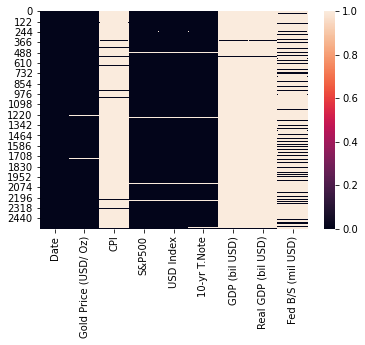

In [ ]:
#getting a high level sense of missing data 
sns.heatmap(dfraw.isnull())

Interpolate method has been chosen to fill the missing macroeconomic data and transform the dataset from monthly/ quartlerly into daily, given the objective is to examine the trend.<br>
The remaining missing data (mainly 2020 Nov data) has been filled with forward fill, as there is no clear trend until new data is released. 

In [ ]:
#filling missing data - interpolate method
df= dfraw.interpolate().sort_values(by=['Date'])
df = df.ffill()
df.tail()

,Date,Gold Price (USD/ Oz),CPI,S&P500,USD Index,10-yr T.Note,GDP (bil USD),Real GDP (bil USD),Fed B/S (mil USD)
4,2020-11-11,1860.95,260.209,3572.66,93.04,0.96,21157.635,18583.984,7175417.0
3,2020-11-12,1874.85,260.209,3537.01,92.96,0.88,21157.635,18583.984,7175417.0
2,2020-11-13,1890.90,260.209,3585.15,92.76,0.89,21157.635,18583.984,7175417.0
1,2020-11-16,1885.60,260.209,3626.91,92.57,0.91,21157.635,18583.984,7175417.0
0,2020-11-17,1889.05,260.209,3609.53,92.42,0.87,21157.635,18583.984,7175417.0


As the unit/ base of each column in the dataset ranges extremely widely (from percentage based data to aggragated economic output data in billions), the data has been scaled. As such, it preserves the trend of the original distribution and did not reduce the importance of outliers if any.

In [ ]:
#scaling the data
df_scale = df.set_index('Date')
df_scale_index = df_scale.index
df_scale_columns = df_scale.columns
df_scale = scale(df_scale)
df_scale

array([[-0.37833718, -1.98063939, -1.56716151, ..., -1.66153037,
        -1.59739895, -1.72794593],
       [-0.3914829 , -1.97820991, -1.58183482, ..., -1.66050358,
        -1.59684588, -1.72794593],
       [-0.31021844, -1.97578043, -1.54404428, ..., -1.65947679,
        -1.59629281, -1.72794593],
       ...,
       [ 2.3686405 ,  1.80433092,  2.3184927 , ...,  1.36010924,
         1.0749944 ,  3.06738919],
       [ 2.34330511,  1.80433092,  2.38502444, ...,  1.36010924,
         1.0749944 ,  3.06738919],
       [ 2.35979702,  1.80433092,  2.35733474, ...,  1.36010924,
         1.0749944 ,  3.06738919]])

In [ ]:
#putting the scaled data into dataframe
dfscaled = pd.DataFrame(df_scale, index=df_scale_index, columns=df_scale_columns)
dfscaled.head()

,Gold Price (USD/ Oz),CPI,S&P500,USD Index,10-yr T.Note,GDP (bil USD),Real GDP (bil USD),Fed B/S (mil USD)
Date,,,,,,,,
2010-10-01,-0.378337,-1.980639,-1.567162,-1.356407,0.531735,-1.661530,-1.597399,-1.727946
2010-10-04,-0.391483,-1.978210,-1.581835,-1.313567,0.452298,-1.660504,-1.596846,-1.727946
2010-10-05,-0.310218,-1.975780,-1.544044,-1.396868,0.436411,-1.659477,-1.596293,-1.727946
2010-10-06,-0.233734,-1.973351,-1.545287,-1.439708,0.325200,-1.658450,-1.595740,-1.727946
2010-10-07,-0.240905,-1.970921,-1.548330,-1.439708,0.325200,-1.657423,-1.595187,-1.727593


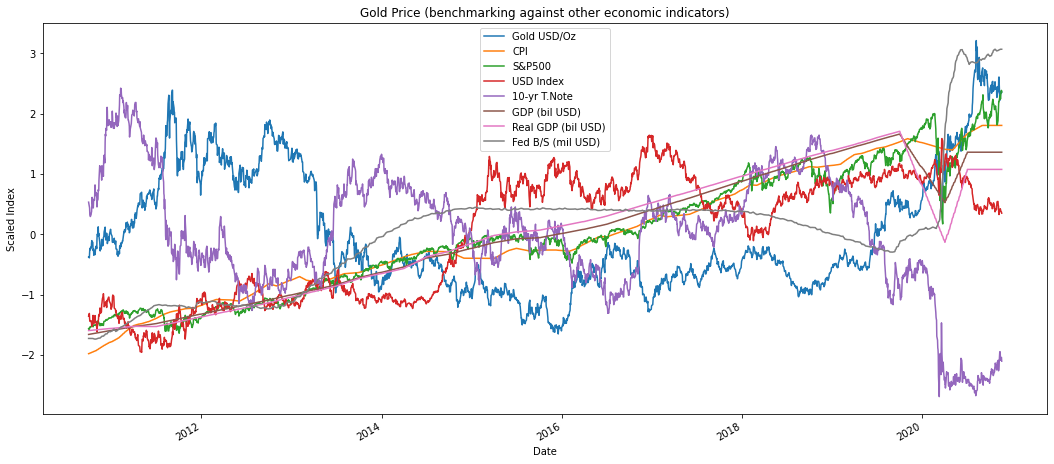

In [ ]:
dfscaled['Gold Price (USD/ Oz)'].plot(label='Gold USD/Oz',figsize=(18,8), title='Gold Price (benchmarking against other economic indicators)')
dfscaled['CPI'].plot(label='CPI')
dfscaled['S&P500'].plot(label='S&P500')
dfscaled['USD Index'].plot(label='USD Index')
dfscaled['10-yr T.Note'].plot(label='10-yr T.Note')
dfscaled['GDP (bil USD)'].plot(label='GDP (bil USD)')
dfscaled['Real GDP (bil USD)'].plot(label='Real GDP (bil USD)')
dfscaled['Fed B/S (mil USD)'].plot(label='Fed B/S (mil USD)')

plt.xlabel('Date')
plt.ylabel('Scaled Index')
plt.legend();

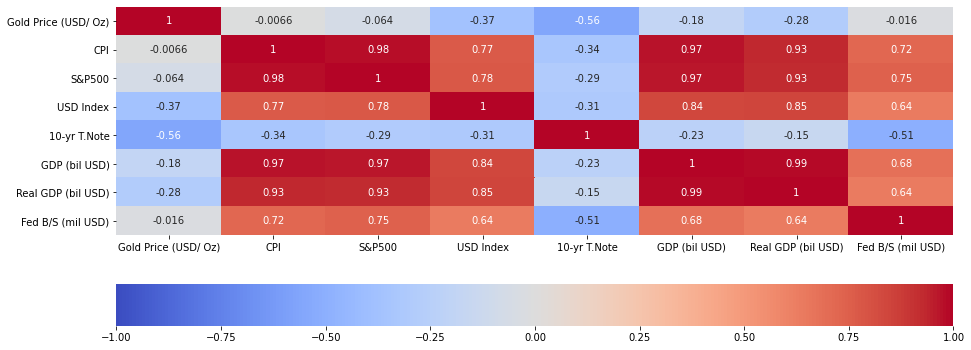

In [ ]:
plt.figure(figsize=(15,6))
sns.heatmap(dfscaled.corr(), annot = True, vmin=-1, vmax=1, center=0, cmap='coolwarm', cbar_kws= {'orientation': 'horizontal'})